In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)

([<matplotlib.lines.Line2D at 0x214b9a43620>], (4995, 1))

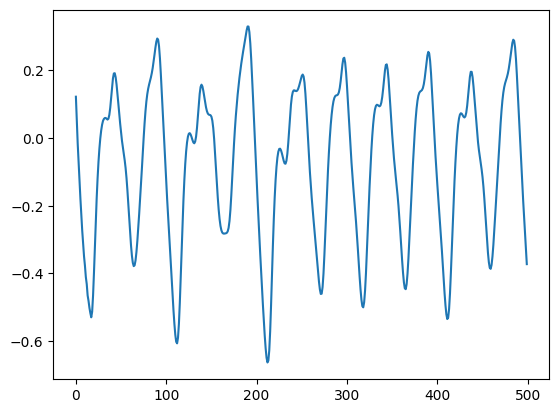

In [3]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.plot(dataset[:500]), dataset.shape

### Splits of dataset

In [4]:
train_test_ratio = 0.8
train_size = int(len(dataset) * train_test_ratio)
test_size = len(dataset) - train_size

train_data, test_data = train_test_split(dataset, train_size=train_size, test_size=test_size)

train_data.shape, test_data.shape

((3996, 1), (999, 1))

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


GPU is available


In [6]:
#train_data = torch.tensor(np.array([data[0] for data in train_dataset]).reshape(-1, 1)).to(device)
#test_data = torch.tensor(np.array([data[0] for data in test_dataset]).reshape(-1, 1)).to(device)
#train_data

# ESN 

In [7]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)

esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.05)
criterion = nn.MSELoss()

In [8]:
inputs, targets = Mglass1[0]

inputs = inputs.to(device) 
targets = targets.to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)

readout.weight is on cuda:0
readout.bias is on cuda:0
cuda:0 cuda:0


In [9]:
losses = esn.Train(inputs, targets, epochs=100, lr=0.05, 
                         print_every=10)

Epoch 100, Iteration 0, Loss: 0.08206064999103546
Epoch 100, Iteration 10, Loss: 0.03335986286401749
Epoch 100, Iteration 20, Loss: 0.01588694378733635
Epoch 100, Iteration 30, Loss: 0.005059395916759968
Epoch 100, Iteration 40, Loss: 0.0011727632954716682
Epoch 100, Iteration 50, Loss: 0.0008802616503089666
Epoch 100, Iteration 60, Loss: 0.0007834738353267312
Epoch 100, Iteration 70, Loss: 0.0005273509887047112
Epoch 100, Iteration 80, Loss: 0.00048140541184693575
Epoch 100, Iteration 90, Loss: 0.00041901852819137275


device(type='cuda', index=0)

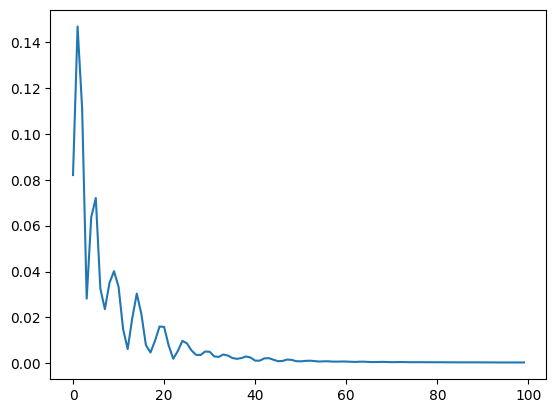

In [10]:
plt.plot(losses.cpu().detach().numpy())
inputs.device

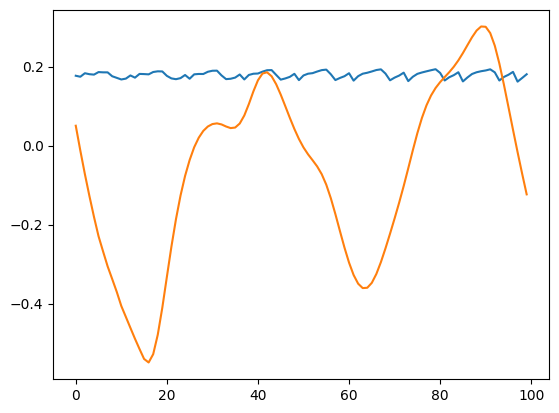

In [11]:
esn.Predict(inputs, 100)
plt.plot(esn.Predict(inputs, 100).cpu().detach().numpy(), label='Prediction')
plt.plot(targets[:100].cpu().detach().numpy(), label='True')
plt.show()

In [ ]:
Reservoir_states = esn.res_states().to(device)
Readout = esn.readout_layer().to(device)
Reservoir_state = esn.res_state().to(device)
reservoir_W = esn.res_w().to(device)
W_in = esn.w_in().to(device)
Reservoir_states.size(), Reservoir_state.size(), Readout

(torch.Size([999, 200]),
 torch.Size([200]),
 Linear(in_features=200, out_features=1, bias=True))

In [ ]:
r_state_last = Reservoir_state.to(device)
preds = inputs[-1].to(device)

In [ ]:
r_state_last = torch.tanh(torch.matmul(reservoir_W, r_state_last)
                  + torch.matmul(W_in, preds))
pred = esn.readout(r_state_last)
esn.update_reservoir(r_state_last)
preds = torch.cat((preds, pred), dim=0)
preds

RuntimeError: size mismatch, got input (200), mat (200x1), vec (2)

In [ ]:
#TODO
# 1. Prediction method should update the reservoir states. 
# 2. Add prediction loop to get x number of prediction.